In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
columns = ['event', 'time', 'u_Id', 'type',
           'queue', 'arr cust', 'depar cust', "in line"]

In [3]:
# Client
class Client:
    """
    Class implementig the client in the queue
    """

    def __init__(self, u_Id, type, arrival_time) -> None:
        self.u_Id = u_Id
        self.type = type
        self.arrival_time = arrival_time

    def getType(self):
        return self.type

    def getArrivalTime(self):
        return self.arrival_time

    def getId(self):
        return self.u_Id

In [5]:
class Hyperexp(stats.rv_continuous):
    """
    An HyperExponential Random Variable
    credits: https://github.com/pixki/redesestocasticas/blob/master/phasedist.py
    """

    def __init__(self, alpha=0.5, lambda1=1/95 * (-2 - np.sqrt(194)), lambda2=1/95 * (np.sqrt(194) - 2)):
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def rvs(self, size=1):
        vsample = np.vectorize(self._single_sample)
        return np.fromfunction(vsample, (size,))

    def _single_sample(self, size):
        U1 = np.random.random()
        if U1 <= self.alpha:
            scale = self.lambda1
        else:
            scale = self.lambda2
        U2 = np.random.random()

        return -np.log(U2)/scale

    def pdf(self, x):
        a = self.alpha*self.lambda1*np.exp(self.lambda1*-x)
        b = (1-self.alpha)*self.lambda2*np.exp(self.lambda2*-x)
        return a + b

    def mean(self):
        return (self.alpha / self.lambda1) + ((1-self.alpha) / self.lambda2)

    def standard_dev(self):
        a = (self.alpha/(self.lambda1**2)) + ((1-self.alpha)/(self.lambda2**2))
        return np.sqrt(2*a + self.mean()**2)

    def cdf(self, x):
        a = self.alpha*(-np.exp(self.lambda1*-x))
        b = (1-self.alpha)*(-np.exp(self.lambda2*-x))
        return a + b + 1

    def CoV(self):
        a = np.sqrt(2*self.alpha/self.lambda1 + 2*(1-self.alpha)/self.lambda2 -
                    (self.alpha/self.lambda1 + (1-self.alpha)/self.lambda2)**2)
        return a/self.mean()

In [9]:
def block_average(arr, n, plot=False):
    """
    divide the input array in blocks and compute the average of each block ("smoothing")
    :param arr: numpy array or list
    :param n: lenght of each block
    :param plot: boolean value that specifies if the function has to plot or no the "smoothed" array
    :return: average of each block
    """
    j = 0
    means = []
    for i in range(n, len(arr), n):
        mean = np.mean(arr[j:i])
        means.append(mean)
        j = i
    mean = np.mean(arr[j:])
    means.append(mean)

    if plot:
        plt.plot(means)
        plt.show()

    return means

In [10]:
def cum_mean(arr, plot=False):
    """
    compute the cumulative mean of the input array
    :param arr: numpy array or list
    :param plot: boolean value that specifies if the function has to plot or no the cumulative mean
    :return: cumulative mean
    """
    cum_sum = np.cumsum(arr, axis=0)
    for i in range(cum_sum.shape[0]):
        if i == 0:
            continue
        #print(cum_sum[i] / (i + 1))
        cum_sum[i] =  cum_sum[i] / (i + 1)

    if plot:
        plt.plot(cum_sum)
        plt.show()

    return cum_sum

In [11]:
def detect_transient(arr, n, verbose=False):
    """
    Return the n-th time the input array is decreasing (end of transient)
    :param arr: numpy array or list
    :param n: threshold
    :param verbose:
    :return: the position of the end of the transient
    """
    i = 1
    count = 0
    for i in range(1, len(arr)-1):
        if arr[i-1] > arr[i]:
            count+=1

        if count >= n:
            if verbose:
                print(f"transient detected in [0, {i}]")
            return i

    if verbose:
        print("no transient detected")
    return -1

In [12]:
def remove_transient(arr, n, plot=False):
    """
    remove the transient (i.e. return the values of the cum_mean of the array from position n to the end)
    :param arr: input array
    :param n: position of the end of the transient
    :param plot:
    :return: the input arraywith the transient removed
    """
    c_mean = cum_mean(arr)
    # c_mean = arr
    c_mean[:n] = np.zeros(n)

    if plot:
        plt.plot(cum_mean(arr))
        plt.plot(c_mean)
        plt.show()

    return c_mean, c_mean[n:], arr[n:]

In [13]:
def confidance_interval(x, alpha=.95):
    """
    compute the alpha-% confidence interval of the values in x
    :param x: list of values
    :param alpha: percentage of the confidence interval
    :return: lower and upper bound of the c.i., mean and critical value
    """
    mean, sigma = np.mean(x), np.std(x)
    conf_down, conf_up = stats.norm.interval(alpha, loc=mean, scale=sigma/np.sqrt(len(x)))
    z = stats.norm.interval(alpha)[1] * (sigma/np.sqrt(len(x)))

    return conf_down, conf_up, mean, z

In [14]:
def batch_means(arr, p, n_batches):
    """
    apply the batch means method
    :param arr: numpy array or list
    :param p: 1 - alpha
    :param n_batches: initial number of batches
    :return: mean, lower and upper bound of the c.i.
    """
    means = []
    for batch in np.array_split(arr, n_batches):
        means.append(np.mean(batch))

    conf_down, conf_up, x, z = confidance_interval(means)

    # print((2 * z / x))
    if (2 * z / x) > p:
        pass
    else:
        return x, conf_down, conf_up

    # print("no confidence interval")
    return -1, -1, -1

In [15]:
class QueueSimulator:
    """
    class that implements a queue with a single server
    """
    def __init__(self, ARRIVAL, DEPARTURE, SIZE_LIMIT, type, batch_size, n, p, seed) -> None:
        self.ARRIVAL = ARRIVAL
        self.DEPARTURE = DEPARTURE
        self.SIZE_LIMIT = SIZE_LIMIT
        self.type = type
        self.batch_size = batch_size
        self.n = n
        self.p = p
        self.seed = seed

        np.random.seed(self.seed)
        random.seed(seed)

        self.u_Id = 0
        self.users = 0
        self.queue = []
        self.FES = []

        self.columns = ['event', 'time', 'u_Id', 'type',
                        'queue', 'arr cust', 'depar cust', "in line"]
        self.df = pd.DataFrame(columns=self.columns)
        self.delays = []

        self.batches = 10
        self.ci = (0,0)
        self.x = 0

    def reset_queue(self):
        self.u_Id = 0
        self.users = 0
        self.queue = []
        self.FES = []
        self.df = pd.DataFrame(columns=self.columns)
        self.delays = pd.DataFrame(columns=["time", "in line"])
        self.batches = 10

    def set_params(self, ARRIVAL, DEPARTURE, SIZE_LIMIT, type, batch_size, n, p, seed):
        self.reset_queue()

        self.ARRIVAL = ARRIVAL
        self.DEPARTURE = DEPARTURE
        self.SIZE_LIMIT = SIZE_LIMIT
        self.type = type
        self.batch_size = batch_size
        self.n = n
        self.p = p
        self.seed = seed

    def print_params(self):
        print(f"ARRIVAL RATE: {self.ARRIVAL}")
        print(f"SERVICE RATE: {self.DEPARTURE}")
        print(f"SIZE LIMIT: {self.SIZE_LIMIT}")
        print(f"batch size: {self.batch_size}")
        print(f"n: {self.n}")
        print(f"p: {self.p}")
        print(f"seed: {self.seed}")

    def add_to_df(self, l):
        self.df.loc[len(self.df)] = l

    def compute_delays(self):
        # self.delays = self.df.groupby("u_Id")["time"].diff()[self.df.groupby("u_Id")["time"].diff().notnull()].tolist()
        self.delays = self.df[["time", "in line"]]

    def get_df(self):
        return self.df

    def get_delays(self):
        return self.delays

    def store_results(self, x, down, up):
        self.x = x
        self.ci = (down, up)

    def get_x(self):
        return self.x

    def get_confidance_interval(self):
        return self.ci

    def plot(self):
        cumulative_mean = cum_mean(self.delays["in line"], True)
        end_transient_position = detect_transient(cumulative_mean, self.n * self.ARRIVAL, False)
        # end_transient_position = detect_transient(cumulative_mean, self.n, False)
        remove_transient(self.delays["in line"], end_transient_position, True)

    def arrival(self, time, FES, queue):
        # print("ARRIVAL at time: \t{}".format(time))
        # create a record for the client
        client = Client(self.u_Id, 0, time)
        self.u_Id += 1

        # sample time until next event
        inter_arrival = random.expovariate(self.ARRIVAL)

        if self.SIZE_LIMIT > 0:
            if len(queue) > self.SIZE_LIMIT:
                self.u_Id -= 1
                FES.append((time + inter_arrival, -1, "skip"))
                return

        # schedule next arrival
        FES.append((time + inter_arrival, client.getId() + 1, "arrival"))
        # update state variables
        self.users += 1
        # print("new CLIENT [{}] created of type [{}] at time [{}]".format(client.getId(), client.getType(), client.getArrivalTime()))
        # insert record in the queue
        queue.append(client)

        # if server is idle start the service
        if self.users == 1:
            # sample the service time
            if self.type == "exp":
                service_time = random.expovariate(self.DEPARTURE)
            elif self.type == "det":
                service_time = 1
            elif self.type == "hyper":
                h = Hyperexp()  # mean=1, std=10
                service_time = h.rvs()
            else:
                print("ERROR!!")

            # print("new DEPARTURE scheduled at time: {}".format(time + service_time))

            # schedule when the client will finish the server
            FES.append((time + service_time, client.getId(), "departure"))

    def departure(self, time, FES, queue):
        # get the first element from the queue
        client = queue.pop(0)
        # print("CLIENT {} of type [{}] created at time [{}] departed at time [{}]".format(client.getId(), client.getType(), client.getArrivalTime(), time))
        # update state variable
        self.users -= 1

        # see wheather there are more clients to serve in the line
        if self.users > 0:
            # sample the service time
            if self.type == "exp":
                service_time = random.expovariate(self.DEPARTURE)
            elif self.type == "det":
                service_time = 1
            elif self.type == "hyper":
                h = Hyperexp()  # mean=1, std=10
                service_time = h.rvs()
            else:
                print("ERROR!!")
            # schedule when the client will finish the server
            FES.append((time + service_time, queue[0].getId(), "departure"))

    def simulate(self):
        """
        simulate of the queue
        :return: None
        """
        self.reset_queue()
        self.print_params()

        # simulation time
        time = 0

        # event counter
        event = 0
        arrivals = 0
        departures = 0

        # schedule the first arrival at t=0
        self.FES.append((time, self.u_Id, "arrival"))

        while True:
            # sort FES in order to ave events in cronological order
            self.FES.sort(key=lambda x: x[0])
            (time, Id, event_type) = self.FES.pop(0)

            # if queue size is finite
            if event_type == "skip":
                self.arrival(time, self.FES, self.queue)

            elif event_type == "arrival":
                event += 1
                arrivals += 1

                l = [event, float(time), Id, "arrival", len(self.queue), arrivals, departures, self.users]
                self.add_to_df(l)

                self.arrival(time, self.FES, self.queue)

            elif event_type == "departure":
                event += 1
                departures += 1

                l = [event, float(time), Id, "departure", len(self.queue), arrivals, departures, self.users]
                self.add_to_df(l)

                self.departure(time, self.FES, self.queue)

            else:
                print("ERROR!!")
                break


            if event == self.batch_size * self.batches:
                self.compute_delays()
                delays = self.get_delays()

                cumulative_mean = cum_mean(delays["in line"])
                end_transient_position = detect_transient(cumulative_mean, self.n * self.ARRIVAL, False)
                # end_transient_position = detect_transient(cumulative_mean, self.n, False)

                if end_transient_position != -1:
                    _, steady_state, _ = remove_transient(delays["in line"], end_transient_position, False)
                    x, down, up = batch_means(steady_state, self.p, self.batches)

                    if x != -1:
                        self.store_results(x, down, up)
                        break
                    else:
                        self.batches+=1

        print(f"CONFIDANCE INTERVAL: {self.ci}")
        print(f"mean: {self.x}")

In [16]:
arrival_rates = [.2, .5, .7, .9, .99]

In [17]:
sim = QueueSimulator(ARRIVAL=.5, DEPARTURE=1, SIZE_LIMIT=10, type="det", batch_size=300, n=400, p=.05, seed=42)

In [18]:
"""
Run the experiment for the Expenontial service time
"""
delays_exp = []
conf_int_exp = []
for arrival_rate in arrival_rates:
    sim.set_params(ARRIVAL=arrival_rate, DEPARTURE=1, SIZE_LIMIT=10000, type="exp", batch_size=1000, n=1000, p=.05, seed=42)
    sim.simulate()
    delays_exp.append(sim.get_delays())
    conf_int_exp.append(sim.get_confidance_interval())
    # sim.plot()

ARRIVAL RATE: 0.2
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (0.7337261342965585, 0.7428211137203876)
mean: 0.7382736240084731
ARRIVAL RATE: 0.5
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (1.4660370238454736, 1.5251332162072635)
mean: 1.4955851200263686
ARRIVAL RATE: 0.7
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (2.563579405110448, 2.691263492891988)
mean: 2.627421449001218
ARRIVAL RATE: 0.9
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (7.835014257931482, 8.23369579342542)
mean: 8.034355025678451
ARRIVAL RATE: 0.99
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (99.60462182276626, 104.70979457115331)
mean: 102.15720819695979


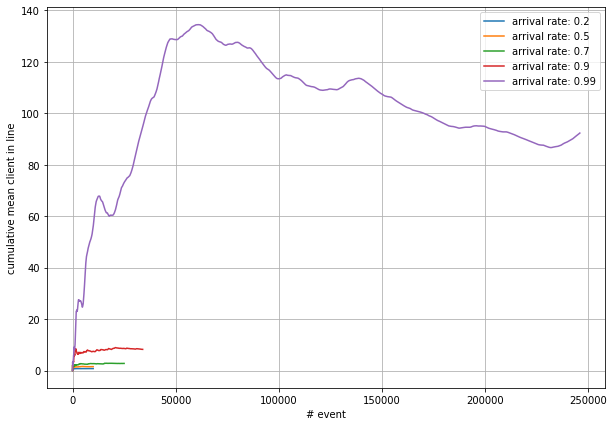

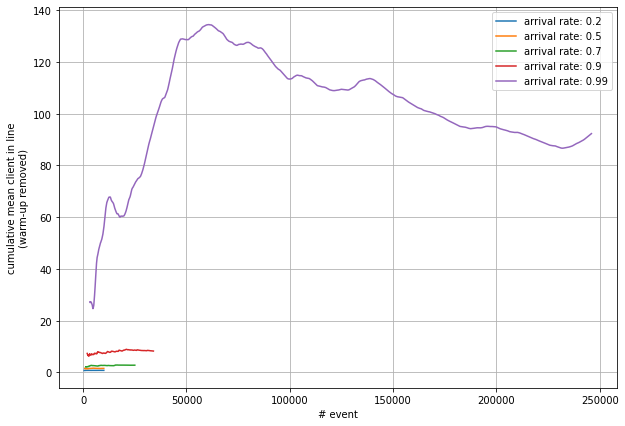

In [19]:
plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_exp, arrival_rates):
    c = cum_mean(delay["in line"])
    plt.plot(c, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line")
plt.grid()
plt.savefig("res/delays_exp.png")
plt.show()

plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_exp, arrival_rates):
    c = cum_mean(delay["in line"])
    n = detect_transient(c, arrival_rate*1000)
    _, r, _ = remove_transient(delay["in line"], n)
    plt.plot(r, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line\n(warm-up removed)")
plt.grid()
plt.savefig("res/delays_exp_transient.png")
plt.show()

In [20]:
"""
Run the experiment for the Deterministic service time
"""
delays_det = []
conf_int_det = []
for arrival_rate in arrival_rates:
    sim.set_params(ARRIVAL=arrival_rate, DEPARTURE=1, SIZE_LIMIT=10000, type="det", batch_size=1000, n=1000, p=.05, seed=42)
    sim.simulate()
    delays_det.append(sim.get_delays())
    conf_int_det.append(sim.get_confidance_interval())
    # sim.plot()

ARRIVAL RATE: 0.2
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (0.698114724448319, 0.7102745067564868)
mean: 0.7041946156024029
ARRIVAL RATE: 0.5
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (1.2301672180065453, 1.2397039751192567)
mean: 1.234935596562901
ARRIVAL RATE: 0.7
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (1.9122733886747645, 1.9598624824367976)
mean: 1.936067935555781
ARRIVAL RATE: 0.9
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (5.07535518894459, 5.3309092784187015)
mean: 5.203132233681646
ARRIVAL RATE: 0.99
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (9.48337738715251, 9.966758802759914)
mean: 9.725068094956212


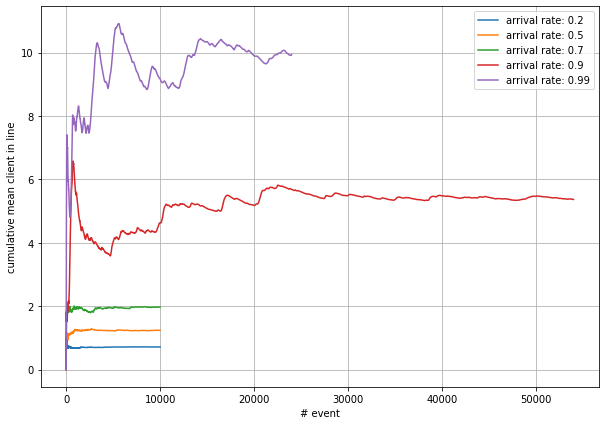

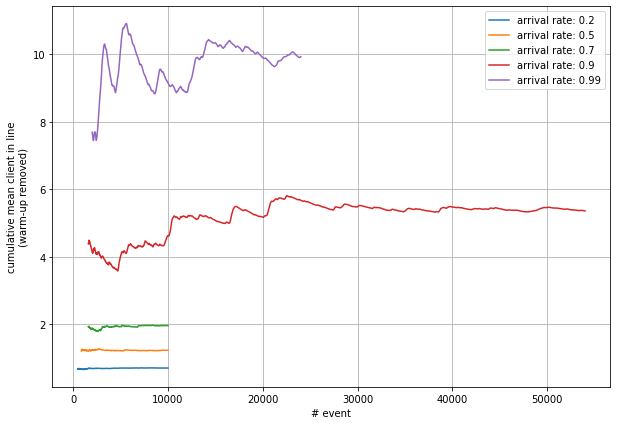

In [21]:
plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_det, arrival_rates):
    c = cum_mean(delay["in line"])
    plt.plot(c, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line")
plt.grid()
plt.savefig("res/delays_det.png")
plt.show()

plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_det, arrival_rates):
    c = cum_mean(delay["in line"])
    n = detect_transient(c, arrival_rate*1000)
    _, r, _ = remove_transient(delay["in line"], n)
    plt.plot(r, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line\n(warm-up removed)")
plt.grid()
plt.savefig("res/delays_det_transient.png")
plt.show()

In [ ]:
"""
Run the experiment for the Hyperexponential service time
"""
delays_hyper = []
conf_int_hyper = []
for arrival_rate in arrival_rates:
    sim.set_params(ARRIVAL=arrival_rate, DEPARTURE=1, SIZE_LIMIT=10000, type="hyper", batch_size=1000, n=1000, p=.05, seed=42)
    sim.simulate()
    delays_hyper.append(sim.get_delays())
    conf_int_hyper.append(sim.get_confidance_interval())
    # sim.plot()

ARRIVAL RATE: 0.2
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (3.3338756577875737, 3.5016127092572313)
mean: 3.4177441835224025
ARRIVAL RATE: 0.5
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (26.627605980349735, 27.97629651847288)
mean: 27.301951249411307
ARRIVAL RATE: 0.7
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42
CONFIDANCE INTERVAL: (66.54236685710039, 69.94137200887691)
mean: 68.24186943298865
ARRIVAL RATE: 0.9
SERVICE RATE: 1
SIZE LIMIT: 10000
batch size: 1000
n: 1000
p: 0.05
seed: 42


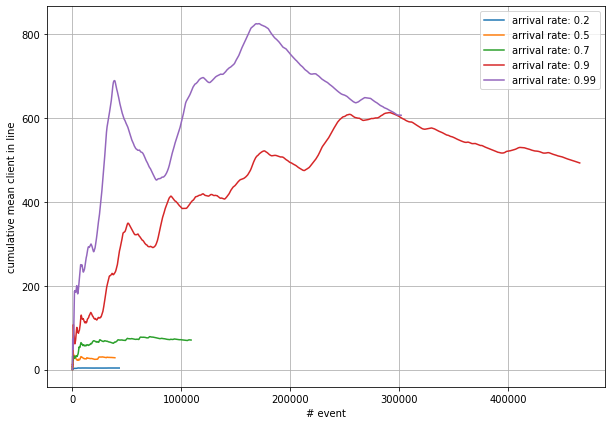

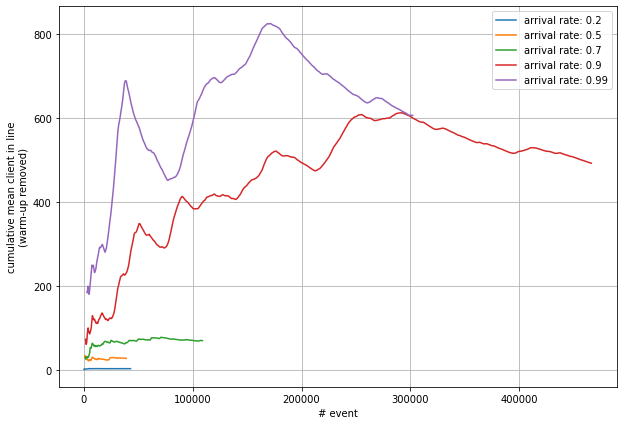

In [25]:
plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_hyper, arrival_rates):
    c = cum_mean(delay["in line"])
    # plt.ylim((0, 1))
    plt.plot(c, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line")
plt.grid()
plt.savefig("res/delays_hyper.png")
plt.show()

plt.figure(figsize=(10,7))
for delay, arrival_rate in zip(delays_hyper, arrival_rates):
    c = cum_mean(delay["in line"])
    n = detect_transient(c, arrival_rate*1000)
    _, r, _ = remove_transient(delay["in line"], n)
    #plt.ylim((0, 1))
    plt.plot(r, label=f"arrival rate: {arrival_rate}")

plt.legend()
plt.xlabel("# event")
plt.ylabel("cumulative mean client in line\n(warm-up removed)")
plt.grid()
plt.savefig("res/delays_hyper_transient.png")
plt.show()